The code is adapted from the Pyro example to fit the educational structure of the Problang chapter. I attempted to stay as close to the webbook as possible, but some minor alterations have been made. ~ Marv

In [1]:
# first some imports
import torch
torch.set_default_dtype(torch.float64) # double precision for numerical stability

import collections
from collections import namedtuple

import argparse
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine

from pyro_rsa_book_utils.search_inference import Marginal, marginalize
from pyro_rsa_book_utils import visualize

# Chapter 9: Social reasoning about social reasoning

In this chapter, we will see:
* How to extend the vanilla RSA model by editing the Utility function
* How to formalize tradeoffs between different communicative goals
* When to go beyond the 3-layer vanilla RSA 

When using language, speakers aim to get listeners to believe the things that they believe. But sometimes, we don’t want listeners to know exactly how we feel. Imagine your date bakes you a batch of **flax seed, sugar-free, gluten-free cookies** before your big presentation next week. (What a sweetheart.) You are grateful for them — something to take your mind off impending doom. But then you bite into them, and you wonder if they actually qualify as cookies and not just fragments of seed glued together. Your date asks you what you think. You look up and say __“They’re good.”__

Politeness violates a critical principle of cooperative communication: exchanging **information efficiently and accurately**. If information transfer were the only currency in communication, a cooperative speaker would find polite utterances undesirable because they are potentially misleading. But **polite language** use is critical to making sure your date doesn’t charge out of the room before you can qualify what you meant by the more truthful and informative __“These cookies are terrible.”__

Brown and Levinson (1987) recast the notion of a cooperative speaker as one who has both an **epistemic goal** to correctly update the listener’s knowledge state as well as a **social goal** to minimize any potential damage to the hearer’s (and the speaker’s own) self-image, which they called face. [Yoon, Tessler, et al. (2016)](http://langcog.stanford.edu/papers_new/yoon-2016-cogsci.pdf) formalize a version of this idea in the RSA framework by introducing a new component to the speaker’s utility function: **social utility**.

## 1. A new speaker

The usual speaker utility from RSA is a suprisal-based, epistemic utility:

$$U^{S_1}_{epistemic}(u;s)=\log P_{L_0}(s|u)$$

Social utility can be defined as the expected subjective utlity of the state the listener would infer given the utterance $u$:

$$U^{S_1}_{social}(u;s) = \mathbb{E}_{P_{L_0}(s'|u)}[V(s')] =\sum_{s'}V(s')P_{L_0}(s'|u),$$

where $V$ is a value function that maps states to subjective utility values - this captures the affective consequences for the listener of being in state $s$.

Speaker utility is then a _mixture_ of these components:

$$U^{S_1}(u;s;\varphi)=\varphi\cdot U_{epistemic}(u;s)+(1-\varphi)\cdot U_{social}(u;s),$$

where $\varphi\in [0,1]$ is a model parameter determined by experiment (see below).

Note that at this point, we do not differentiate subjective state value **to the listener** from subjective state value **to the speaker**, though in many situations these could in principle be different. Also at this point, we do not allow for _deception_ or _meanness_, which would be the exact opposite of epistemic and social utilities, respectively - though this could very naturally be incorporated: [Yoon et al. (2016)](http://langcog.stanford.edu/papers_new/yoon-2016-cogsci.pdf), model **meanness** by having independent weights on the two utilities.

In _Pyro_, this could look like the following:

In [2]:
# these could be given like in the introduction
state = ... # s
l0_dist = ... # p(s|u)

value_function = ... # V()
expectation = lambda distr, func: \
    torch.sum(torch.cat([distr.log_prob(x).exp() * func(x) for x in distr.enumerate_support()]))

Utility = namedtuple("Utility", ("epistemic","social"))

# util = Utility(
#    l0_dist.log_prob(state),
#    expectation(literal_listener_dist, value_function)
# )

phi = 0.8
# speaker_utility = phi * util.epistemic + (1-phi) * util.social

```expectation``` computes the expected value (or _mean_) of the distribution supplied to it as the first argument. The second argument is a _projection function_, for when you want the expectation computed with respect to some transformation of the distribution's support:

$$\mathbb{E}_{dist}[func]:=\sum_ifunc(x_i)\mathbb{P}_{dist}(x_i),$$
for finite support $x_1,\ldots,x_n$. Think of it as a weighted average.

Here, ```value_function``` should project the listener's distribution from world states onto subjective valuations of those world states (e.g., the subjective value of a listener believing the cookies they baked were rated 4.5 out of possible 5 stars).

## An Example

We consider a simplified case study of the example given at the beginning, shown in Figure 1 below. The listener has completed some task or produced some product (e.g., basked a cake) and solicits the speaker's feedback, Performance on the task maps to a scale raning from 1 to 5 hearts (shown below; cf. online product reviews). These are the states of the world that the speaker can be informative with respect to.  Below, the speaker thinks the cake deserves 3 out of 5 hearts.

<center> <img src='../../img/yoon-hearts.jpeg' width="400" height="400" align="middle"> </center>

__Fig. 1__: Politeness case study

At the same time, these states of the world also have some inherent subjective value: 5 hearts is better than 3 hearts. $\varphi$ governs how much the speaker seeks to communicate information about the state vs. make the listener believe she is in a highly valued state.

We start once again with a literal listener whose task is to interpret **value judgments** (e.g. "terrible", "okay", "amazing") according to their literal semantics. The literal listener model assumed here is the exact same as in the vanilla RSA model of __Chapter 1__:

$$P_{L_0}(s|u)\propto[[u]](s)\cdot P(s)$$

In [3]:
# speaker's possible secret true judgements
states = [1, 2, 3, 4, 5]

# uniform distribution over speaker states
def state_prior():
    prior_dist = dist.Categorical(probs=torch.ones(len(states))/len(states))
    idx = pyro.sample("state", prior_dist)
    return states[idx]

# what we let the speaker choose from
utterances = [
    "terrible",
    "bad",
    "okay",
    "good",
    "amazing"
]

# correspondence of utterances to states
# (empirically measured)
literal_semantics = {
    "terrible":[.95,.85,.02,.02,.02],
    "bad":[.85,.95,.02,.02,.02],
    "okay":[0.02,0.25,0.95,.65,.35],
    "good":[.02,.05,.55,.95,.93],
    "amazing":[.02,.02,.02,.65,0.95]
}

# helper function
# to determine whether the utterance describes the state
# by flipping a coin with 
# the literal_semantics[utterance][state] weight
def meaning(utterance, state): 
    # meaning(u, s) := [[u]](s) in the notation above 
    weight = literal_semantics[utterance][state-1]
    bernoulli = dist.Bernoulli(probs=weight)
    m = pyro.sample("meaning", bernoulli)
    return m

# literal listener
@Marginal
def literal_listener(utterance):
    state = state_prior()
    # values below are log probs
    pyro.factor("literal_meaning", 0. if meaning(utterance, state) else -999999.)
    return state

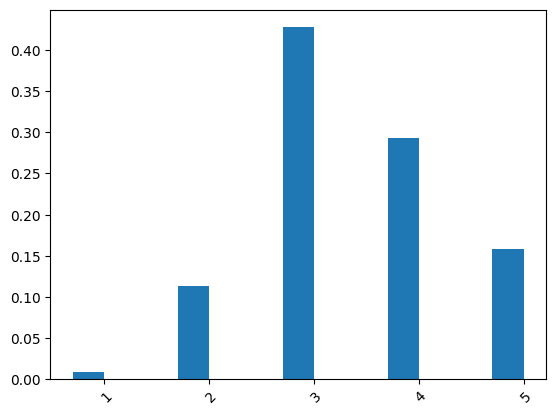

In [4]:
utterance = "okay"
l0_dist = literal_listener(utterance)
visualize(l0_dist)

## Exercises 1 a)
1. Why do the lists in ```literal_semantics``` not sum to one? Can a given list be interpreted as either of $P(s|\cdot)$, $P(\cdot|u)$, $P(\cdot|s)$ or $P(u|\cdot)$? Which one? Is this a probability distribution?
2. Test the predictions of ```literal_listener``` for the various utterances.

Next, we add in the speaker, who reasons about the literal llistener with respect to an epistemic and a social goal. The speaker model assumed here is exactly like in the vanilla RSA model o,f Chapter 1, except that we use the utility function introduced above:

$$P_{S_1}(u|s;\varphi)\propto\exp(\alpha\cdot U(s;u;\varphi))$$

In [5]:
# value function scales social utility by a parameter lambda
lambda_ = 1.25 # MAP estimate from Yoon, Tessler, et al. (2016)
value_function = lambda state: lambda_ * state

# alpha = 10 # MAP estimate from Yoon, Tessler, et al. (2016)
alpha = 1

def utterance_prior():
    prior_dist = dist.Categorical( probs = torch.ones(len(utterances)) / len(utterances) )
    idx = pyro.sample("utterance", prior_dist)
    return utterances[idx]

@Marginal
def speaker1(state, phi=1):
    utterance = utterance_prior()
    l0_posterior = literal_listener(utterance)
    
    Util = Utility(
        l0_posterior.log_prob(state),
        expectation(l0_posterior, value_function)
    )
    s1_utility = phi * Util.epistemic + (1-phi) * Util.social
    
    pyro.factor("s1_util", alpha * s1_utility)
    return utterance

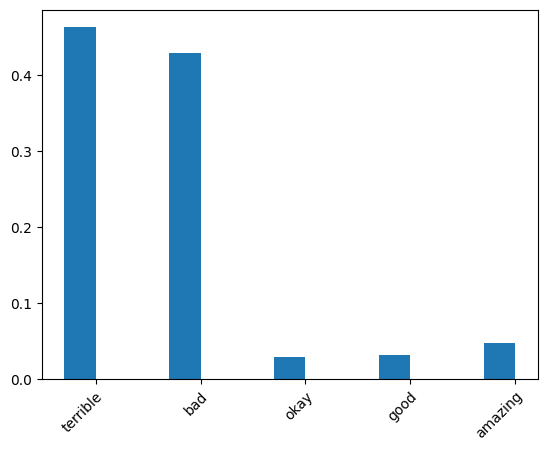

In [6]:
s1_dist = speaker1(1, 0.8)
visualize(s1_dist)

## Exercises 1 b)
1. Describe the kind of speaker assumed by the above function call (```speaker(1, 0.8)```).
2. Change the call to the speaker to make it so that it only cares about making the listener feel good.
3. Change the call to the speaker to make it so that it cares about both making the listener feel good and conveying information.
4. Change the value of ```lambda_``` and examine the results.
5. Change the value of ```alpha``` and interpret the parameter.

## 2. A listener who understands politeness
If different speakers can have different weights on the mixture parameter ```phi```, which governs the trade-off between kindness and informativity, listeners may have uncertainty about **what kind of speaker** they are interacting with (Another motivation is to interpret the kindness vs. informativity behind a single utterance, for a known speaker.). This can be captured by endowing the ```pragmatic_listener``` from __Chapter 1__ with a prior distribution over ```phi```, corresponding to uncertainty about the parameter of the speaker's utility function. The resulting pragmatic listener is a **joint-inference model**, that infers world state and ```phi```-parameter at the same time:

$$P_{L_1}(s,\varphi|u)\propto P(s)\cdot P(\varphi)\cdot P_{S_1}(u|s,\varphi)$$

In [23]:
def phi_prior():
    # possible phis:
    phis = torch.arange(start=0.00, end=1.0, step=0.05)
    uniform = dist.Categorical(torch.ones(len(phis)) / len(phis))
    idx = pyro.sample("phi", uniform)
    return phis[idx]
    
@Marginal
def pragmatic_listener(utterance):
    
    # your code here
    state = state_prior()
    phi = phi_prior()
    s1_dist = speaker1(state, phi)
    
    s1_utterance = pyro.sample("l1_sim_of_s1", s1_dist)
    
    pyro.factor("l1", 0. if s1_utterance == utterance else -99999.)
    
    return state, phi

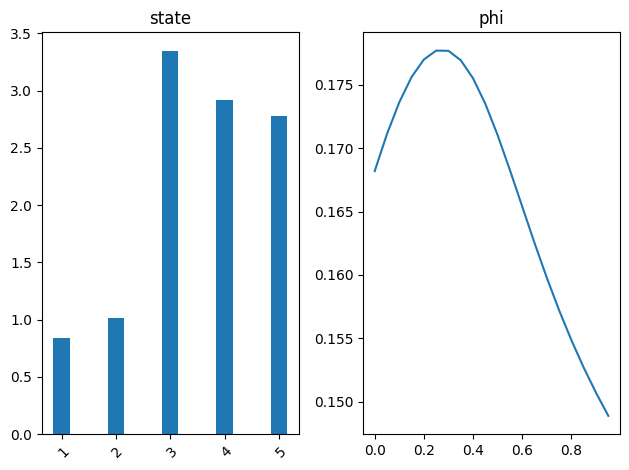

In [24]:
l1_dist = pragmatic_listener("good")
visualize(l1_dist, x_name="state", y_name="phi")

Above, we have a listener who hears that they did "good" and infers how well they actually did, as well as how much the speaker values honesty vs. kindness.

### Exercises 2
0. Implement the pragmatic listener.
1. Examine the marginal posterions on ```state```. Does this make sense? Compare it to what the ```literal_listener``` would believe upon hearing the same utterance.
2. Examine the marginal posterior on ```phi```. Does this make sense? What different utterance would make the ```pragmatic_listener``` infer something different about ```phi```? Test your prediction by running that utterance through the ```pragmatic_listener```.
3. The authors also ran an experiment testing participants' intuitions if they knew what state of the world they were in. Modify ```pragmatic_listener```so that they know what state of the world they are in. Come up with your own interesting situations (i.e., choose a state and an utterance) and show the model predictions. Are the predicctions in accord with your intuitions? Why or why not?
4. Modify ```pragmatic_listener``` so that they **know** the speaker __either__:
* wants the listener to feel good __or__
* wants to convey information to the listener __or__
* both. Test all 3 models on the utterance "good".

## 3. Politeness with indirect speech acts

Above, we modeled the case study of **white lies**, utterances which convey misleading information for purposes of politeness. There are other ways to be polite, however. Speakers may deliberately be **indirect** for considerations of **politeness**. Consider a listener who just gave an objectively terrible presentation. They look fragile as they come to you for your feedback. You tell them "_It wasn't bad._".

Why would somebody produce such an indirect speech act? If the speaker wanted to actually be nice, they would say "_It was fine._" or "_It was great_.". If the speaker wanted to actually convey information, they would say "_It was terrible._". 

[Yoon et al. (2017)](https://cogsci.mindmodeling.org/2017/papers/0679/paper0679.pdf) and [Yoon, Tessler et al. (2018)](https://psyarxiv.com/67ne8) hypothesize that speakers produce indirect speech acts in order to _appear_ to care both about conveying information and saving the listener's face.

Can we elaborate the model above to account for politeness by being indirect?  

First, we can define the speaker's utility, defined now with respect to the pragmatic listener $L_1$:

\begin{align}
    U^{S_2}_{epistemic}(u;s) &= \log P_{L_1}(s|u) \\
    U^{S_2}_{social}(u) &= \mathbb{E}_{P_{L_1}(s^\prime|u)}[V(s^\prime)]=\sum_{s^\prime}V(s^\prime)\cdot P_{L_1}(s^\prime|u) \\
    P_{L_1}(s|u) &= \int_\varphi P_{L_1}(s,\varphi|u) d\varphi
\end{align}

Here, $V$ is again the **value function** from before that maps states to subjective utility values. With our higher-order speaker, however we have a new utility component: a **self-presentational utility** - defined with respect to the pragmatic listener's inferences about the politeness mixture component $\varphi$:

$$U^{S_2}_{presentational}(u)=\log P_{L_1}(\varphi|u)=\log \int_sP_{L_1}(s,\varphi|u)ds$$

Speaker utility is the a mixture of these three components, weighted by mixture component vector $\omega$:

$$U^{S_2}(u;s;\varphi;\omega)=\omega_{epistemic}\cdot U^{S_2}_{epistemic}(u;s)+\omega_{social}(u)\cdot U^{S_2}_{social}(u)+\omega_{presentational}(u)\cdot U^{S_2}_{presentational}(u)$$

and the new speaker model is again simply a softmax utility speaker:

$$P_{S_2}(u|s,\varphi)\propto\exp(\alpha\cdot U^{S_2}(u;s;\varphi;\omega))$$

The code below defines such a speaker:

In [25]:
alpha2 = 1

@Marginal
def speaker2(state, phi, omega):
    # your code here
    utterance = utterance_prior()
    l1_dist = pragmatic_listener(utterance)
    
    # ---- marginal posterior distributions ----
    
    # speaker's simulation of l1's marginal state posterior
    # ("what state would l1 probably infer from this utterance?")
    l1_state = marginalize(l1_dist, 0)
    
    # speaker's simulation of l1's marginal goal posterior
    # ("what goal would l1 probably infer from this utterance?")
    l1_goal = marginalize(l1_dist, 1)
    
    util_epistemic = l1_state.log_prob(state)
    util_presentational = l1_goal.log_prob(phi)
    util_social = expectation(l1_state, value_function)
    
    s2_utility = omega.epistemic * util_epistemic + \
            omega.social * util_social + \
        omega.presentational * util_presentational
    
    pyro.factor("s2", alpha2 * s2_utility)
    
    # your code here

    return utterance

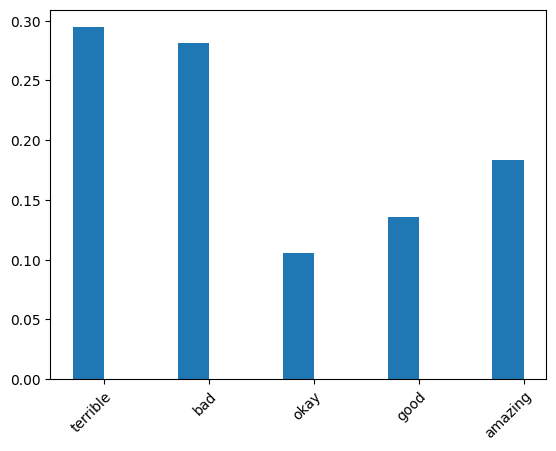

In [37]:
Omega = namedtuple("Omega", ("epistemic", "social", "presentational"))
s2_dist = speaker2(1, 0.0, Omega(0.8, 0.1, 0.1))
visualize(s2_dist)

### Exercises 3
1. Implement `speaker2` based on the description given above.
2. Try out different combinations for $\omega$.

## Gricean Maximes

Pragmatics concerns how **assumptions about cooperation**, **context** and **shared knowledge** can be used in conversation to enrich utterances beyond their literal semantics, and how this ultimately leads to more efficient communication.  

The most well-known set of assumptions are the **Gricean Maxims** (Grice, 1975):

1. Maxim of **Quality**: Be truthful.
2. Maxim of **Quantity**: Be as informative as required, but not more.
3. Maxim of **Relation**: Be relevant.
4. Maxim of **Manner**: Be clear, unambiguous and brief.

Grice argued that:
1. Listeners expect Speakers to adhere to these Maxims.
2. Speakers can __exploit__ these assumptions by violating them to convey additional information.

### Exercises 4
1. Which Maxims were exploited by $S_2$?
2. Which Maxims were exploited by $S_1$ in the reference game notebook? 
3. How can adherence to each of the Maxims be treated in RSA? 
4. Discuss which Maxims might be exploited in typical cases of: 
---
1. __Irony__
2. __Metaphor__
3. __Hyperbole__
4. __Politeness__
5. __Humor__